In [1]:
#!/usr/bin/python
import math
from math import * 
from numpy import *
import numpy as np
import matplotlib.pyplot as plt

from scipy import sqrt
from numba import jit
from array import *
from neuron import h, gui
import neuron
neuron.load_mechanisms('/Users/mortezarouhani/Documents/PulseProfile_app2/Sensory_Model')
# Model Globals

def NAN(m,n):
    A=np.empty((m,n))
    A[:]=np.nan
    return A

def size(A):
    m=len(A)
    n=len(A[0,:])
    return [m,n]

def myrange(a,b,h):
    n=int((b-a)/h)
    arry=np.zeros(n+1)
    for i in range(n+1):
        arry[i]=a+i*h
    return arry
    
def print_proc(arry,m,n):
    #[m,n]=size(arry)
    for i in range(m):
        for j in range(n):
            print("\t", arry[i][j])
        print("\n")

In [2]:
class Pulse:
    def __init__(self, PW, PA):
        self.PW=PW
        self.PA=PA


class Source:
    def __init__(self, Res, Cap, shape,x,y,z):
        self.Res=Res
        self.Cap=Cap
        self.shape=shape
        self.x=x
        self.y=y
        self.z=z
        
        
class Axon:
     def __init__(self,x,y,diam): 
            #self.dist=dist
            self.diam=diam
            self.x=x
            self.y=y

class time_info:
    def  __init__(self,Neuron_dt,Total_Rec):
        self.Neuron_dt=Neuron_dt
        self.Total_Rec=Total_Rec

-2.0611567997486449143e-09

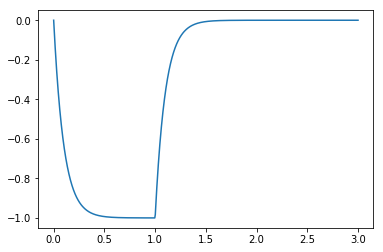

In [3]:
def PulseProfile_RC(pulse, source, timeinfo):
    
    #Generates potential patern induced by the source
    
    num = round(timeinfo.Total_Rec/timeinfo.Neuron_dt)
    num1 = 1
    tmin = 0
    tmax = (timeinfo.Neuron_dt/1000)*num  #seconds
    
    t = linspace(tmin,tmax,num)
    
    R=source.Res
    C=source.Cap
    tau=R*C
    dt=t[1]-t[0]
    
    
    num2 =round(pulse.PW/dt/1000)
    num2 = int(num2)

    
    V=np.float128(np.zeros(num))
    V[0:num2]=pulse.PA*R*(1-np.exp(-t[0:num2]/tau))
    V[num2:num]=pulse.PA*R*np.exp(-t[num2:num]/tau)*(np.exp(pulse.PW/tau/1000)-1)
    
    return t*1000, V/max(abs(V))

def PulseProfile_SQ(pulse, source, timeinfo):
    
    #Generates potential patern induced by the source
    
    num = round(timeinfo.Total_Rec/timeinfo.Neuron_dt)
    num1 = 1
    tmin = 0
    tmax = (timeinfo.Neuron_dt/1000)*num  #seconds
    
    t = linspace(tmin,tmax,num)
    #print(t)
    R=source.Res
    C=source.Cap
    tau=R*C
    dt=t[1]-t[0]
    #print(tau)
    
    num2 =round(pulse.PW/dt/1000)
    num2 = int(num2)

    
    V=np.zeros(num)
    V[0:num2]=1
    V[num2:num]=0
    
    
    return t*1000, V/max(abs(V))
Res = 20e3
Cap = 5e-9
Neuron_dt=0.005
axonnodes=21
PW=1
PA=-80
pulse=Pulse(PW,PA)
Total_Rec=3*pulse.PW
timeinfo=time_info(Neuron_dt,Total_Rec)


source=Source(Res,Cap,'RC',200,0,0)     
axon=Axon(56.86148212, -6.11443186,  7.        )

t,v=PulseProfile_RC(pulse, source, timeinfo)
plt.plot(t,v)
v[-1]

In [4]:
def vectrorProduct(vv,ve):
    v_stim=np.zeros([len(vv),len(ve)])

    for i in range(len(vv)):
        for j in range(len(ve)):
            v_stim[i,j]=vv[i]*ve[j]
        
    return v_stim

def Find(w,item):
    r=[]
    for i in range(len(w)):
        if w[i]==item:
            r.append(i)
            
    return r
    
        

In [5]:
def sensoryLIFE(pulse, source ,axon,timeinfo):
#%% Adaptive Neural Systems Laboratory (2019)
#%  Enhanced Surface Electrical Neurostimulation (eSENS)
#%  Simulations and Human Subject Studies, PhD Project by Andres E Pena
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#% Modified script based on Gaines 2018 model for TES
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#% This script generates the NEURON extracellular voltage profiles
#% along the length of a sensory axon over a given time.
#% This was originally used in a full arm model of surface
#% electrical stimulation (Gaines 2018), and in that case very long axons
#% were needed. Neuron checks for an action potential in one node.
#% The start time of the stimulus is variable in Neuron.
#% This is because there is a small depolarization that happens upon
#% initialization of the model and this delay allows the membrane potential
#% to stabilize.
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#% This function is released to be used in NEURON simulations (MATLAB based profile)
#% Version: ANS-eSENS-01.03 (Andres Pena 08/02/2019)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#%% LOCAL SETUP / PARAMETERS / FLAGS
#% This sections contains main parameters relevant to this function


    NEURON_Path = '/Users/mortezarouhani/Documents/PulseProfile_app2/Sensory_Model';


    #%% Characteristics of the stimmulation source(s)
    I=-pulse.PA/1000    #Injected current in mA
    # Location of each source
    # Source A (Representing Voice 1 in stimulator)


    Ay=abs(axon.y-source.y)      #micrometers perpendicular distance of the point source from the center of the axon.
    Az=abs(source.z)              #z offset. In micrometers, distance to offset the stimulus along the axon. Default is centered over the center node.
    Ax=abs(axon.x-source.x)             #Could do an offset in the x direction
    
   
    
    PShape = source.shape  # RC or SQ
    Res = source.Res
    Cap = source.Cap
    
    # Characteristics of the simulated sensory fiber
    number_nodes=axonnodes     #Odd number is best
    fiberD=axon.diam    #um
    


    # Select where the AP will be "recorded"
    # To select Custom Node(0), Specify the node in CustomNode variable
    Where2Check = 1   # Start(1), Middle(2), or End(3) of the sensory fiber
    CustomNode = 10   # This is the node where the voltage will be checked for an action potential in NEURON.
    dt = timeinfo.Neuron_dt        # in ms this is set in NEURON

    # These are in um (micrometers)
    n=1                              # node width
    m=3                              # mysa width
    f=(2.5811*fiberD)+19.59
    deltax=969.3*log(fiberD)-1144.6  #Distance between nodes
    s=(deltax-n-(2*m)-(2*f))/6       #stin width

    widths=[n, m, f, s, s, s, s, s, s, f, m]

    if number_nodes%2 == 0 :
    #number is even
        w=np.tile(widths,(number_nodes))
    #w=cat(2,w,widths(1:6));
    else:
    #number is odd
        w=np.tile(widths,(number_nodes-1)) 
        w=np.append(w,[1])
    #print(len(w))
    centers=w/2 #middle of each segement ex. middle of each node, middle of each mysa...
    z=[]

    for b in range(len(w)):
        z=np.append(z,[centers[b]+np.sum(w[0:b])-centers[0]]) #um z=transvers distance up and down the arm from the point source to the position on the axon
    #print(len(z))
    cond_long=1/(3e6)  #ohm*um longitudinal conductivity
    cond_trans=1/(1.2e7) #ohm*um transverse conductivity
    #?????????????????? OR Simens/um
    #the uniform media:
    #cond_long=cond_trans;

    # A
    #Calculates voltage along nerve at the center of each segment (z)

    #Ve_A=I./(4*pi*sqrt((Ax.^2*cond_long*cond_trans)'+(Ay.^2*cond_long*cond_trans)'+(z.^2*cond_trans^2)'))';  %voltage in mV


    Ve = zeros(len(w))
    Ve = I/(4*pi*sqrt(Ax*Ax*cond_long*cond_trans+Ay*Ay*cond_long*cond_trans+np.multiply(z,z)*cond_trans**2))
    #print(Ve)
    #voltage of A in mV
    #Ve(2,:) = I./(4*pi*sqrt((Bx.^2*cond_long*cond_trans)'+(By.^2*cond_long*cond_trans)'+(z.^2*cond_trans^2)'))';  %voltage of B in mV



        
    # PlotFlag = 'plot';
    PlotFlag = 'noplot'
    RC_vals = [Res, Cap]
    RC_Tau_ms = 1000*Res*Cap
        
        
    EV_Duration = timeinfo.Total_Rec#+RC_Tau_ms    # in ms, Duration of the extracellular potential recording from COMSOL
        
    ProfileDur = round(EV_Duration/dt)
    #print(ProfileDur)
        
    TT = zeros(ProfileDur) 
    VV = zeros(ProfileDur)

    if PShape=='SQ':
        TT,VV = PulseProfile_SQ(pulse, source, timeinfo)
    else:
        TT,VV = PulseProfile_RC(pulse, source, timeinfo)   
        
    #print(VV)
    Fdist = z #Distance vector to simulate (um)
    Simulated_V = zeros([len(Fdist),len(TT)+1])
        
        #         VV_Sim = VV'.*Simulated_V(:,2);
        
    VV_Sim = vectrorProduct(VV,Ve)
    #print(size(VV_Sim))
    V_left= fliplr(VV_Sim)
    VVV=np.delete(VV_Sim,0,1)
    #print(size(VVV))
    V_final=np.concatenate((V_left,np.delete(VV_Sim,0,1)), axis=1)
    #print((V_final))
   # w_left=w[::-1]
    #w_final=np.concatenate((w_left,w[1:len(w)]),axis=0)
    w_final=w
    #print(len(w_final))
    nodes=Find(w_final,n)
    mysas=Find(w_final,m)
    fluts=Find(w_final,f)
    stins=Find(w_final,s)
    #print(len(mysas)+len(fluts)+len(stins)+len(nodes))
    
    v_nodes=VV_Sim[:,nodes]
    v_mysas=VV_Sim[:,mysas]
    v_fluts=VV_Sim[:,fluts]
    v_stins=VV_Sim[:,stins]
    
    
    return w_final,V_final,v_nodes, v_mysas,v_fluts, v_stins

Res = 20e3
Cap = 5e-9
Neuron_dt=0.05
axonnodes=21
PW=1
Total_Rec=3*PW
PA=-80
timeinfo=time_info(Neuron_dt,Total_Rec)
pulse=Pulse(PW,PA)
Total_Rec=3*pulse.PW

source=Source(Res,Cap,'SQ',200,0,0)     
axon=Axon(56.86148212, -6.11443186,  7.        )
w,V,node_volt,mysa_volt,flut_volt,stin_volt=sensoryLIFE(pulse, source ,axon,timeinfo)
sqrt((200-56.86148212)**2+6.11443186**2)
print(node_volt)

[[266.61156414  96.09307918  50.57331099 ...   5.72184723   5.42082533
    5.14988785]
 [266.61156414  96.09307918  50.57331099 ...   5.72184723   5.42082533
    5.14988785]
 [266.61156414  96.09307918  50.57331099 ...   5.72184723   5.42082533
    5.14988785]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]


In [6]:
def packing(radii,bol):
    N=len(radii)
    from pprint import pprint as pp
    
   
    s=''
    import circlify as circ
    circles = circ.circlify(list(radii), show_enclosure=bol)
    for i in range(len(radii)):
        s=s+str(circles[i])
    s=s.replace('Circle(','')
    s=s.replace('ex=None)','')
    s=s.replace('y=','')
    s=s.replace('x=','')
    s=s.replace('r=','')
    s=s.replace('level=0,','')
    s=s.replace('level=1,','')
    s=s.replace(' ','')
    ss=s[0:len(s)-1]

    circles=np.zeros((N,3))
    

    p=0
    j=0
    for k in ss.split(','):
        circles[p//3][p%3]=float(k)
        p=p+1
    
    q=radii[-1]/circles[N-1][2]
    circles=q*circles
    circles[:,2]=sort(radii)
    return circles

def circles_plot(circles_Arg):
    [M,N]=size(circles_Arg)
    th = linspace(0,2*np.pi,50)
    
    circle_colors=np.array([[1,0.2,0.1,1],
              [1,0.5,0.3,1],
              [1,0.8,0.4,1],
              [0.9,1,0.5,1],
              [0.7,0.9,0.3,1],
              [0,1,0,1],
              [0.5,0.7,0.5,1],
              [0.4,0.7,0.6,1],
              [0.3,0.5,0.8,1],
              [0,0.2,1,1]])
    plt.figure
    r=0
    t=-1
    for i in range(M):
        if r!=circles_Arg[i][2]:
                    t=t+1
        r=circles_Arg[i][2]
        #print(t,i)
        xunit = r * cos(th) + circles_Arg[i][0]
        yunit = r * sin(th) + circles_Arg[i][1] 
        #plt.plot(xunit, yunit,color=circle_colors[t,:])
        plt.plot(xunit, yunit,color='black')
        plt.axis('equal')
        axes = plt.gca()
        axes.set_xlim([-200,200])
        axes.set_xlim([-200,200])
    #plt.hold(True)

    plt.show()
diam=range(6,26,2)

hist=np.array([6.1,5.1,6.1,10.2,16.3,20.4,21.4,7.2,4.1,3.1])


fiberNum=75
radii=np.zeros(fiberNum)
trgt1=np.round((fiberNum)/100*hist)
trgt=trgt1.astype(int)
k=0
for i in range(len(diam)): 
     for j in range(trgt[i]):
        radii[k]=diam[i]/2
        k=k+1

#k=0
len(radii)


75

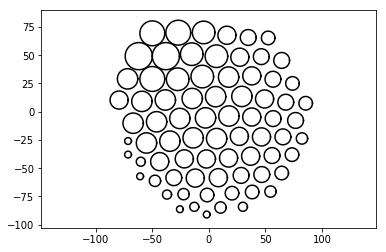

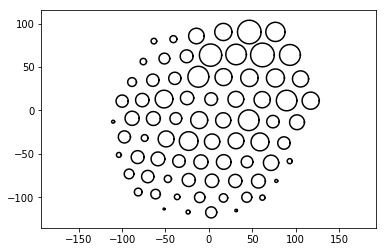

75

In [7]:
circles=packing(radii,False)
circles_plot(circles)


space_factor=5
space=(space_factor*np.random.rand(fiberNum))
#space=space_factor*np.ones(fiberNum+1)

circles_spaced=packing(sort(radii+space),False)
circles_spaced[:,2]=circles_spaced[:,2]-space
circles_plot(circles_spaced)
#circles_spaced[:,2]-radii
len(space)

In [8]:
from astropy.io import ascii
import os
fiberNumbr=np.zeros(1) #np.empty([2,1],dtype=int)
fiberNumbr[0]=str(int(fiberNum))

crcl = NAN(fiberNum,5)

FBNUM=np.array([fiberNum-1])

crcl[0:fiberNum,2:5]=circles_spaced[0:fiberNum,:]
crcl[0,0]=fiberNum-1
crcl[0,1]=3

os.chdir('Sensory_Model')   
#np.savetxt('circles.dat', q*circles  , delimiter=' ',newline=' \n  NaN  NaN',encoding='str')
#np.savetxt('fiberNum.dat', fiberNumbr)
ascii.write(crcl,'circles.dat',overwrite=True)
ascii.write(FBNUM,'fiberNum.dat',overwrite=True)

In [9]:

circles[23]


array([56.86148212, -6.11443186,  7.        ])

In [10]:
Res = 20e3
Cap = 5e-9
Neuron_dt=0.005
axonnodes=21
PW=0.1
PA=-80
pulse=Pulse(PW,PA)
Total_Rec=3*pulse.PW
timeinfo=time_info(Neuron_dt,Total_Rec)
source=Source(Res,Cap,'SQ',50,0,0) # 'RC' or 'SQ'

node_volt=np.zeros([fiberNum,round(Total_Rec/Neuron_dt),axonnodes])
mysa_volt=np.zeros([fiberNum,round(Total_Rec/Neuron_dt),2*(axonnodes-1)])
flut_volt=np.zeros([fiberNum,round(Total_Rec/Neuron_dt),2*(axonnodes-1)])
stin_volt=np.zeros([fiberNum,round(Total_Rec/Neuron_dt),6*(axonnodes-1)])
#print(fiberNum,round(Total_Rec/Neuron_dt),axonnodes)


for i in range(fiberNum):
    axon=Axon(circles[i][0],circles[i][1],circles[i][2])
    w,V,node_volt[i,:,:],mysa_volt[i,:,:],flut_volt[i,:,:],stin_volt[i,:,:]=sensoryLIFE(pulse, source ,axon,timeinfo)
#np.savetxt('nodesTest.dat', n, delimiter=' ',newline='   NAN  NAN  \n')
size(mysa_volt[1])

[60, 40]

In [11]:
NODE=NAN(round(Total_Rec/Neuron_dt)+1,axonnodes+2)
NODE[0][0]=round(Total_Rec/Neuron_dt)
NODE[0][1]=round(axonnodes)
NODE[1:round(Total_Rec/Neuron_dt)+1,2:(axonnodes+2)]=node_volt[23]

ascii.write(NODE,'nodes.dat',overwrite=True)
size(mysa_volt[23])

MYSA=NAN(round(Total_Rec/Neuron_dt)+1,2*axonnodes)
MYSA[0][0]=round(Total_Rec/Neuron_dt)
MYSA[0][1]=2*axonnodes-2
MYSA[1:2*round(Total_Rec/Neuron_dt)-1,2:(2*axonnodes)]=mysa_volt[23]

ascii.write(MYSA,'mysas.dat',overwrite=True)

FLUT=NAN(round(Total_Rec/Neuron_dt)+1,2*axonnodes)
FLUT[0][0]=round(Total_Rec/Neuron_dt)
FLUT[0][1]=2*axonnodes-2
FLUT[1:round(Total_Rec/Neuron_dt)+1,2:2*axonnodes]=flut_volt[23]

ascii.write(FLUT,'fluts.dat',overwrite=True)

STIN=NAN(round(Total_Rec/Neuron_dt)+1,6*axonnodes-4)
STIN[0][0]=round(Total_Rec/Neuron_dt)
STIN[0][1]=6*axonnodes-6
STIN[1:round(Total_Rec/Neuron_dt)+1,2:(6*axonnodes-4)]=stin_volt[23]

ascii.write(STIN,'stins.dat',overwrite=True)
size(STIN)


[61, 122]

[60, 21]


60

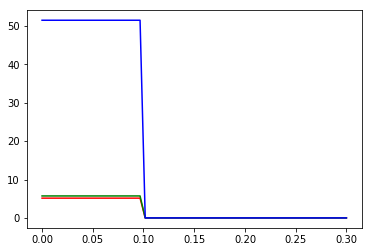

In [12]:
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import cm
#ax = plt.axes(projection='3d')
#fig = plt.figure()
X=np.linspace(0,Total_Rec,round(Total_Rec/Neuron_dt))
Y=np.linspace(1,axonnodes,2*axonnodes)
Z=node_volt[23,:,:]
#ax.plot_surface(X, Y, Z)#,cmap=cm.coolwarm,linewidth=0, antialiased=False)
#size(node_volt[0])
plt.plot(X,Z[:,20],color='red')
plt.plot(X,Z[:,18],color='green')
plt.plot(X,Z[:,2],color='blue')
#print(len(X),len(Y))
print(size(Z)) 
15/0.05
round(Total_Rec/Neuron_dt)

In [ ]:

import os
#os.chdir('Sensory_Model')   
#axonnodes=21
h('dt='+str(timeinfo.Neuron_dt))
model_global="""
objref circles,node_volt,mysa1_volt,mysa2_volt,flut1_volt,flut2_volt,m
objref stin1_volt, stin2_volt, stin3_volt, stin4_volt, stin5_volt, stin6_volt

load_file("noload.hoc")

proc model_globals() {
celsius=37         //degrees C//	// Human body temperature
v_init=-79.3565 //mV//          // starting voltage
 //ms//                  // time step
tstop=25 //ms//                // time at which simulation terminates
        node_volt //mV//                // voltage profile in the node from MAXWELL
        
        mysa1_volt //mV//                // voltage profile in the mysa from MAXWELL
        mysa1_volt //mV//                // voltage profile in the mysa from MAXWELL
        
        flut1_volt //mV//                // voltage profile in the flut from MAXWELL
        flut2_volt //mV//                // voltage profile in the flut from MAXWELL
        stin1_volt //mV//                // voltage profile in the stin from MAXWELL
        stin2_volt //mV//                // voltage profile in the stin from MAXWELL
        stin3_volt //mV//                // voltage profile in the stin from MAXWELL
        stin4_volt //mV//                // voltage profile in the stin from MAXWELL
        stin5_volt //mV//                // voltage profile in the stin from MAXWELL
        stin6_volt //mV//                // voltage profile in the stin from MAXWELL
        
        //fiberDiam  //um//                // Diameter of the axon fiber
        //num_nodes                       // Number of nodes modeled


//Extracellular stimuluation parameters//
delay=15 //ms           // time before the stimulation is applied
pw=.5 //ms            // pulse width, the duration of the stimulation


    
lm=3       // mysa length
ln=1.0      // node length
space_p1=0.002      // mysa periaxonal space width
space_p2=0.004      // flut periaxonal space width
space_i=0.004       // stin periaxonal space width


//morphological parameters//
lm=3       // mysa length
ln=1.0      // node length
space_p1=0.002      // mysa periaxonal space width
space_p2=0.004      // flut periaxonal space width
space_i=0.004       // stin periaxonal space width

//electrical parameters//
rhoa=0.7e6 //Ohm-um//                       //axoplasmic resistivity
mycm=0.1 //uF/cm2/lamella membrane//    // myelin capacitance
mygm=0.001 //S/cm2/lamella membrane//   // myelin conductance

}
model_globals()
"""

h(model_global)
h('node2check='+str(20))



timeSteps=round(Total_Rec/Neuron_dt)

h('timeStepsNum='+str(timeSteps))

h('circles=new Matrix('+str(fiberNum)+',3)')

h('node_volt=new Matrix('+str(timeSteps*fiberNum)+','+str(axonnodes)+')')

h('mysa1_volt=new Matrix('+str(timeSteps*fiberNum)+','+str(axonnodes-1)+')')
h('mysa2_volt=new Matrix('+str(timeSteps*fiberNum)+','+str(axonnodes-1)+')')

h('flut1_volt=new Matrix('+str(timeSteps*fiberNum)+','+str(axonnodes-1)+')')
h('flut2_volt=new Matrix('+str(timeSteps*fiberNum)+','+str(axonnodes-1)+')')

h('stin1_volt=new Matrix('+str(timeSteps*fiberNum)+','+str(axonnodes-1)+')')
h('stin2_volt=new Matrix('+str(timeSteps*fiberNum)+','+str(axonnodes-1)+')')
h('stin3_volt=new Matrix('+str(timeSteps*fiberNum)+','+str(axonnodes-1)+')')
h('stin4_volt=new Matrix('+str(timeSteps*fiberNum)+','+str(axonnodes-1)+')')
h('stin5_volt=new Matrix('+str(timeSteps*fiberNum)+','+str(axonnodes-1)+')')
h('stin6_volt=new Matrix('+str(timeSteps*fiberNum)+','+str(axonnodes-1)+')')


h('axonnodes='+str(axonnodes))
h('fiberNum='+str(fiberNum))

#print(h.circles)

for i in range(fiberNum):
    for j in range(3):
        h.circles.setval(i,j,circles[i][j])
        
for i in range(timeSteps):
    for j in range(axonnodes-1):
        for k in range(fiberNum):
            h.mysa1_volt.setval(k*timeSteps+i,j,mysa_volt[k][i][j])
            h.mysa2_volt.setval(k*timeSteps+i,j,mysa_volt[k][i][j+axonnodes-1])
            
            h.flut1_volt.setval(k*timeSteps+i,j,flut_volt[k][i][j])
            h.flut2_volt.setval(k*timeSteps+i,j,flut_volt[k][i][j+axonnodes-1])
            
            h.stin1_volt.setval(k*timeSteps+i,j,stin_volt[k][i][j])
            h.stin2_volt.setval(k*timeSteps+i,j,stin_volt[k][i][j+axonnodes-1])
            h.stin3_volt.setval(k*timeSteps+i,j,stin_volt[k][i][j+2*(axonnodes-1)])
            h.stin4_volt.setval(k*timeSteps+i,j,stin_volt[k][i][j+3*(axonnodes-1)])
            h.stin5_volt.setval(k*timeSteps+i,j,stin_volt[k][i][j+4*(axonnodes-1)])
            h.stin6_volt.setval(k*timeSteps+i,j,stin_volt[k][i][j+5*(axonnodes-1)])
for i in range(timeSteps):
    for j in range(axonnodes):
        for k in range(fiberNum):
             h.node_volt.setval(k*timeSteps+i,j,node_volt[k][i][j])
declare_str="""

objref g,axonD,nodeD,paraD1,paraD2,paralength2,nl,Rpn0,Rpn1,Rpn2,Rpx,interlength,fiberDiam,deltax,paralength2,lf,ls,ltotal
g=new Vector(fiberNum)
axonD=new Vector(fiberNum)
nodeD=new Vector(fiberNum)
paraD1=new Vector(fiberNum)
paraD2=new Vector(fiberNum)
paralength2=new Vector(fiberNum)
nl=new Vector(fiberNum)
Rpn0=new Vector(fiberNum)
Rpn1=new Vector(fiberNum)
Rpn2=new Vector(fiberNum)
Rpx=new Vector(fiberNum)
interlength=new Vector(fiberNum)
fiberDiam=new Vector(fiberNum)
deltax=new Vector(fiberNum)
paralength2=new Vector(fiberNum)
lf=new Vector(fiberNum)
ls=new Vector(fiberNum)
ltotal=new Vector(fiberNum)
m=new Vector(fiberNum,0)
"""
h(declare_str)
dependent_str="""
proc dependent_var() {

    // linear interpolation of properties from McIntyre, Richardson, and Grill (2002) for any fiber diameter between 5.7 and 16 um

for k=0,fiberNum-1 {


fiberDiam.x[k]=circles.x[k][2]
g.x[k] = 0.0172*(fiberDiam.x[k])+0.5076    //??
axonD.x[k] = 0.889*(fiberDiam.x[k])-1.9104  //diameter of the axon
nodeD.x[k] = 0.3449*(fiberDiam.x[k])-0.1484 //diameter of the node
paraD1.x[k] = 0.3527*(fiberDiam.x[k])-0.1804 //diameter of paranode 1
paraD2.x[k] = 0.889*(fiberDiam.x[k])-1.9104 //diameter of paranode 2
deltax.x[k] = 969.3*log(fiberDiam.x[k])-1144.6//total length between nodes (including 1/2 the node on each side)
paralength2.x[k] = 2.5811*(fiberDiam.x[k])+19.59 //length of paranode2
nl.x[k] = 65.897*log(fiberDiam.x[k])-32.666 ///number of lamella
lf.x[k] = 2.5811*(fiberDiam.x[k])+19.59  //length of paranode2

Rpn0.x[k]=(rhoa*0.01)/(PI*((((nodeD.x[k]/2)+space_p1)^2)-((nodeD.x[k]/2)^2)))

Rpn1.x[k]=(rhoa*0.01)/(PI*((((paraD1.x[k]/2)+space_p1)^2)-((paraD1.x[k]/2)^2)))

Rpn2.x[k]=(rhoa*0.01)/(PI*((((paraD2.x[k]/2)+space_p2)^2)-((paraD2.x[k]/2)^2)))

Rpx.x[k]=(rhoa*0.01)/(PI*((((axonD.x[k]/2)+space_i)^2)-((axonD.x[k]/2)^2)))

interlength.x[k]=(deltax.x[k]-ln-(2*lm)-(2*paralength2.x[k]))/6
ls.x[k]=(deltax.x[k]-ln-(2*lm)-(2*lf.x[k]))/6

ltotal.x[k]= ln+2*lm+2*lf.x[k]+6*ls.x[k]

//axonD=diameter of the axon
//nodeD=diameter of the node
//paraD1=diameter of paranode 1
//paraD2diameter of paranode 2
//deltax=total length between nodes (including 1/2 the node on each side)
//paralength2=length of paranode2
//n1=number of lamella
}
}

dependent_var()
"""
h(dependent_str)

initilize_str="""
        
create node[fiberNum][axonnodes],MYSA1[fiberNum][axonnodes-1],MYSA2[fiberNum][axonnodes-1] 
create FLUT1[fiberNum][axonnodes-1],FLUT2[fiberNum][axonnodes-1], STIN1[fiberNum][axonnodes-1]
create STIN2[fiberNum][axonnodes-1],STIN3[fiberNum][axonnodes-1],STIN4[fiberNum][axonnodes-1]
create  STIN5[fiberNum][axonnodes-1],STIN6[fiberNum][axonnodes-1]

access node[0][0]

proc initialize(){ 

forall insert extracellular
forall e_extracellular = 0
    
for k=0,fiberNum-1 {

for i=0,axonnodes-1 {

node[k][i]{
            nseg=1
            pt3dadd(circles.x[k][0],  circles.x[k][1],  i*ltotal.x[k], nodeD.x[k]/2)
            pt3dadd(circles.x[k][0],  circles.x[k][1],  (i)*ltotal.x[k]+ln, nodeD.x[k]/2)
            
            Ra=rhoa/10000
            cm=2
            insert node_sensory       // mod file declaring nodal channel properties
            xraxial=Rpn0.x[k]
            xg=1e10
            xc=0
            }
        }
        
 for i=0,axonnodes-2 {  
 {
MYSA1[k][i]{
            nseg=1
            pt3dadd(circles.x[k][0],  circles.x[k][1],  i*ltotal.x[k]+ln, circles.x[k][2])
            pt3dadd(circles.x[k][0],  circles.x[k][1],  (i)*ltotal.x[k]+ln+lm, circles.x[k][2])
            
            Ra=rhoa*(1/(paraD1.x[k]/fiberDiam.x[k])^2)/10000
            cm=2*paraD1.x[k]/fiberDiam.x[k]
            insert mysa_sensory       // mod file declaring nodal channel properties
            xraxial=Rpn1.x[k] xg=mygm/(nl.x[k]*2) xc=mycm/(nl.x[k]*2)
            
            }
            
MYSA2[k][i]{
            nseg=1
            pt3dadd(circles.x[k][0],  circles.x[k][1],  i*ltotal.x[k]+ln+2*lf.x[k]+6*ls.x[k]+lm, circles.x[k][2])
            pt3dadd(circles.x[k][0],  circles.x[k][1],  (i)*ltotal.x[k]+ln+2*lf.x[k]+6*ls.x[k]+2*lm, circles.x[k][2])
            
            Ra=rhoa*(1/(paraD1.x[k]/fiberDiam.x[k])^2)/10000
            cm=2*paraD1.x[k]/fiberDiam.x[k]
            insert mysa_sensory       // mod file declaring nodal channel properties
            xraxial=Rpn1.x[k] xg=mygm/(nl.x[k]*2) xc=mycm/(nl.x[k]*2)
            
            }
    
FLUT1[k][i]{
            nseg=1
            pt3dadd(circles.x[k][0],circles.x[k][1],(i)*ltotal.x[k]+ln+lm, circles.x[k][2])
            pt3dadd(circles.x[k][0],circles.x[k][1],(i)*ltotal.x[k]+ln+lm+lf.x[k], circles.x[k][2])

            Ra=rhoa*(1/(paraD2.x[k]/fiberDiam.x[k])^2)/10000
            cm=2*paraD2.x[k]/fiberDiam.x[k]
            insert flut_sensory      // mod file declaring flut channel properties
            xraxial=Rpn2.x[k] xg=mygm/(nl.x[k]*2) xc=mycm/(nl.x[k]*2)
            }

FLUT2[k][i]{
            nseg=1
            pt3dadd(circles.x[k][0],circles.x[k][1],(i)*ltotal.x[k]+ln+lm+lf.x[k]+6*ls.x[k], circles.x[k][2])
            pt3dadd(circles.x[k][0],circles.x[k][1],(i)*ltotal.x[k]+ln+lm+2*lf.x[k]+6*ls.x[k], circles.x[k][2])

            Ra=rhoa*(1/(paraD2.x[k]/fiberDiam.x[k])^2)/10000
            cm=2*paraD2.x[k]/fiberDiam.x[k]
            insert flut_sensory      // mod file declaring flut channel properties
            xraxial=Rpn2.x[k] xg=mygm/(nl.x[k]*2) xc=mycm/(nl.x[k]*2)
            }
STIN1[k][i]{
            nseg=1
            //diam=fiberDiam
            //L=ls

            pt3dadd(circles.x[k][0],circles.x[k][1],(i)*ltotal.x[k]+ln+lm+lf.x[k], circles.x[k][2])
            pt3dadd(circles.x[k][0],circles.x[k][1],(i)*ltotal.x[k]+ln+lm+lf.x[k]+ls.x[k], circles.x[k][2])

            Ra=rhoa*(1/(axonD.x[k]/fiberDiam.x[k])^2)/10000
            cm=2*axonD.x[k]/fiberDiam.x[k]
            insert stin_sensory      // mod file declaring stin channel properties
            xraxial=Rpx.x[k] xg=mygm/(nl.x[k]*2) xc=mycm/(nl.x[k]*2)
            }  
STIN2[k][i]{
            nseg=1
            //diam=fiberDiam
            //L=ls

            pt3dadd(circles.x[k][0],circles.x[k][1],(i)*ltotal.x[k]+ln+lm+lf.x[k]+ls.x[k], circles.x[k][2])
            pt3dadd(circles.x[k][0],circles.x[k][1],(i)*ltotal.x[k]+ln+lm+lf.x[k]+2*ls.x[k], circles.x[k][2])

            Ra=rhoa*(1/(axonD.x[k]/fiberDiam.x[k])^2)/10000
            cm=2*axonD.x[k]/fiberDiam.x[k]
            insert stin_sensory      // mod file declaring stin channel properties
            xraxial=Rpx.x[k] xg=mygm/(nl.x[k]*2) xc=mycm/(nl.x[k]*2)
            } 
STIN3[k][i]{
            nseg=1
            //diam=fiberDiam
            //L=ls

            pt3dadd(circles.x[k][0],circles.x[k][1],(i)*ltotal.x[k]+ln+lm+lf.x[k]+2*ls.x[k], circles.x[k][2])
            pt3dadd(circles.x[k][0],circles.x[k][1],(i)*ltotal.x[k]+ln+lm+lf.x[k]+3*ls.x[k], circles.x[k][2])

            Ra=rhoa*(1/(axonD.x[k]/fiberDiam.x[k])^2)/10000
            cm=2*axonD.x[k]/fiberDiam.x[k]
            insert stin_sensory      // mod file declaring stin channel properties
            xraxial=Rpx.x[k] xg=mygm/(nl.x[k]*2) xc=mycm/(nl.x[k]*2)
            }  

STIN4[k][i]{
            nseg=1
            //diam=fiberDiam
            //L=ls

            pt3dadd(circles.x[k][0],circles.x[k][1],(i)*ltotal.x[k]+ln+lm+lf.x[k]+3*ls.x[k], circles.x[k][2])
            pt3dadd(circles.x[k][0],circles.x[k][1],(i)*ltotal.x[k]+ln+lm+lf.x[k]+4*ls.x[k], circles.x[k][2])

            Ra=rhoa*(1/(axonD.x[k]/fiberDiam.x[k])^2)/10000
            cm=2*axonD.x[k]/fiberDiam.x[k]
            insert stin_sensory      // mod file declaring stin channel properties
            xraxial=Rpx.x[k] xg=mygm/(nl.x[k]*2) xc=mycm/(nl.x[k]*2)
            } 
STIN5[k][i]{
            nseg=1
            //diam=fiberDiam
            //L=ls

            pt3dadd(circles.x[k][0],circles.x[k][1],(i)*ltotal.x[k]+ln+lm+lf.x[k]+4*ls.x[k], circles.x[k][2])
            pt3dadd(circles.x[k][0],circles.x[k][1],(i)*ltotal.x[k]+ln+lm+lf.x[k]+5*ls.x[k], circles.x[k][2])

            Ra=rhoa*(1/(axonD.x[k]/fiberDiam.x[k])^2)/10000
            cm=2*axonD.x[k]/fiberDiam.x[k]
            insert stin_sensory      // mod file declaring stin channel properties
            xraxial=Rpx.x[k] xg=mygm/(nl.x[k]*2) xc=mycm/(nl.x[k]*2)
            }  
STIN6[k][i]{
            nseg=1
            //diam=fiberDiam
            //L=ls

            pt3dadd(circles.x[k][0],circles.x[k][1],(i)*ltotal.x[k]+ln+lm+lf.x[k]+5*ls.x[k], circles.x[k][2])
            pt3dadd(circles.x[k][0],circles.x[k][1],(i)*ltotal.x[k]+ln+lm+lf.x[k]+6*ls.x[k], circles.x[k][2])

            Ra=rhoa*(1/(axonD.x[k]/fiberDiam.x[k])^2)/10000
            cm=2*axonD.x[k]/fiberDiam.x[k]
            insert stin_sensory      // mod file declaring stin channel properties
            xraxial=Rpx.x[k] xg=mygm/(nl.x[k]*2) xc=mycm/(nl.x[k]*2)
            }  
    }
  }


for i=0,axonnodes-2 {
                    connect node[k][i](1), MYSA1[k][i](0)
                    connect MYSA1[k][i](1),  FLUT1[k][i](0)
                    connect FLUT1[k][i](1),  STIN1[k][i](0)
                    
                    connect STIN1[k][i](1),  STIN2[k][i](0)
                    connect STIN2[k][i](1),  STIN3[k][i](0)
                    connect STIN3[k][i](1),  STIN4[k][i](0)
                    connect STIN4[k][i](1),  STIN5[k][i](0)
                    connect STIN5[k][i](1),  STIN6[k][i](0)
                    
                    connect STIN6[k][i](1),  FLUT2[k][i](0)
                    connect FLUT2[k][i](1),  MYSA2[k][i](0)
               
                    connect MYSA2[k][i](1), node[k][i+1](0)
                    
                    }
                }

finitialize(v_init)
fcurrent()

}
initialize()

objref fih
fih = new FInitializeHandler(0, "set_e_ext(0)")


proc set_e_ext() {
    if ($1 == 0) {
        forall e_extracellular = 0                // set extracellular voltage source to ground
        cvode.event(delay, "set_e_ext(1)")        // when to turn on
        j = 0   //initialize j
       // print 1,j,"does it work?"
    }else if ($1 <= (node_volt.nrow/fiberNum) && $1 > 0) {

              for k=0, fiberNum-1 { 
              
                        node[k][axonnodes-1]{
                            e_extracellular = node_volt.x[k*timeStepsNum+j][axonnodes-1]
                                }
                                
                        for i=0,axonnodes-2 {
                        //print k,i,j,"does it work?"
                            
                            node[k][i]{
                            e_extracellular = node_volt.x[k*timeStepsNum+j][i]
                                }
                        
                            
                        
                            MYSA1[k][i]{
                            e_extracellular = mysa1_volt.x[k*timeStepsNum+j][i]
                                }
                            MYSA2[k][i]{
                            e_extracellular = mysa2_volt.x[k*timeStepsNum+j][i]
                                }
                            
                        
                            FLUT1[k][i]{
                            e_extracellular = flut1_volt.x[k*timeStepsNum+j][i]
                                }
                            FLUT2[k][i]{
                            e_extracellular = flut2_volt.x[k*timeStepsNum+j][i]
                                }
                        
                       
                            STIN1[k][i]{
                            e_extracellular = stin1_volt.x[k*timeStepsNum+j][i]
                                }
                            STIN2[k][i]{
                            e_extracellular = stin2_volt.x[k*timeStepsNum+j][i]
                                }
                            STIN3[k][i]{
                            e_extracellular = stin3_volt.x[k*timeStepsNum+j][i]
                                }
                            STIN4[k][i]{
                            e_extracellular = stin4_volt.x[k*timeStepsNum+j][i]
                                }
                            STIN5[k][i]{
                            e_extracellular = stin5_volt.x[k*timeStepsNum+j][i]
                                }
                            STIN6[k][i]{
                            e_extracellular = stin6_volt.x[k*timeStepsNum+j][i]
                                }
                        }
              }
                        print "Time-point  ",j, dt*j
                        //j = j


          cvode.event(delay + dt*(j), "set_e_ext(j+1)")

    }else if ($1 == node_volt.nrow+1) {
        forall e_extracellular = 0
        //print 2,i,j,"does it work?"
        cvode.event(0, "set_e_ext(0)")
    }
}


//creat m[fiberNum]  // the axon has not fired

// if the voltage is ever higher than 0 V at node node2check, call the process "handle1()"
objref nc, nil
for kk=0, fiberNum-1{
node[kk][node2check] nc = new NetCon(&v(.5), nil)
nc.threshold = 0 // watch out! only one threshold per presyn location
nc.record("handle1(kk)")
print kk
}
proc handle1() {
    print "[Status changed at time ", t, " when node.v = ", node[$1][node2check].v(.5), "]"
    m.x[$1]=3
    cvode.event(t+1e-6)
}


objectvar scene_vector_[1]
{doNotify()}
//

//cvode_active(1) // optional. but fixed step will probably do one extra time step
cvode.condition_order(2) // optional. but much more accurate event time evaluation.

run()


objref p

// save voltage and time at each time-step in node 20
objref vvec, tvec
//create vvec[fiberNum][timeStepsNum], tvec[fiberNum][timeStepsNum]
//for k=0, fiberNum-1{
tvec = new Vector(timeStepsNum)
vvec = new Vector(timeStepsNum)

tvec.record(&t, dt) // record time
vvec.record(&node[0][node2check].v( 0.5 ), dt)
    //}


print "end voltage: "
print v
runStopAt = 5
runStopIn = 1
t = 0  // reset time variable

//print m
//if (m==3){      // the axon fired
//print "[The axon fired at Node ", node2check, ", peak=1]"}
//if (m==2){      // the axon did not fire
//print "[The axon did not fire at Node ", node2check, ", peak=0]"}
// quit()
//*********************************************************************

"""
h(initilize_str)
#print(h.vvrec)
h.load_file('BlenderNEURON.hoc')


	1 


In [ ]:
for i in range(fiberNum):
    print(h.m.x[i])

In [ ]:
node_v = h.Vector()
node_v.record(h.node[23][20](0.5)._ref_v)



t = h.Vector()
t.record(h._ref_t)

#h.tstop = 220 # set the simulation time
#h.dt = 0.025
#h.v_init = -70
h.run()
plt.plot(t,node_v)
plt.show()

In [ ]:
print(h.mysa1_volt)
print_proc(h.node_volt.x,1,15)

In [ ]:
print_proc(node_volt[0],1,15)

In [ ]:
dir(h)

In [ ]:
multiline_string_ ="""                                              for k=0,fiberNum-1 { \n
for i=0,axonnodes-1 { \n
node[k][i]{nseg=1 \n
pt3dadd(circles.x[k][0],  circles.x[k][1],  i*nodelength, circles.x[k][2]) \n
pt3dadd(circles.x[k][0],  circles.x[k][1],  (i+1)*nodelength, circles.x[k][2]) \n
Ra=rhoa/10000 \n
cm=2}}}} \n """
multiline_string_+"hi"

In [ ]:
for i in range(1):
    for j in range(10):
        print("\t",i*j)
    print("\n")